# This project aims to create a binary classification algorithm to know if a bank transaction is fraudulent or not. 

## 0 - Import useful libraries needed for creating the fraud detection

In [197]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, recall_score

## 1 - Checking data quality

For this project, the dataset used to create the fraud detection algorithm come from Kaggle datasets. <br>
It is composed about 24 features (such as gender, transaction amount, whether the transaction is a fraud or not, etc.) and 200,000 rows. <br>
Source: https://www.kaggle.com/datasets/marusagar/bank-transaction-fraud-detection/data

In [64]:
# Load the data
df = pd.read_csv("./data/Bank_Transaction_Fraud_Detection.csv")

In [14]:
# Showing a global view of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Customer_ID              200000 non-null  object 
 1   Customer_Name            200000 non-null  object 
 2   Gender                   200000 non-null  object 
 3   Age                      200000 non-null  int64  
 4   State                    200000 non-null  object 
 5   City                     200000 non-null  object 
 6   Bank_Branch              200000 non-null  object 
 7   Account_Type             200000 non-null  object 
 8   Transaction_ID           200000 non-null  object 
 9   Transaction_Date         200000 non-null  object 
 10  Transaction_Time         200000 non-null  object 
 11  Transaction_Amount       200000 non-null  float64
 12  Merchant_ID              200000 non-null  object 
 13  Transaction_Type         200000 non-null  object 
 14  Merc

In [15]:
# Quick look in the dataframe
df.head()

,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,...,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com
1,7c14ad51-781a-4db9-b7bd-67439c175262,Hredhaan Khosla,Female,51,Maharashtra,Nashik,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,...,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,+9191074XXXXXX,Grocery delivery,hredhaanXXXX@XXXXXX.com
2,3a73a0e5-d4da-45aa-85f3-528413900a35,Ekani Nazareth,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,...,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,+9197745XXXXXX,Mutual fund investment,ekaniXXX@XXXXXX.com
3,7902f4ef-9050-4a79-857d-9c2ea3181940,Yamini Ramachandran,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,...,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,+9195889XXXXXX,Food delivery,yaminiXXXXX@XXXXXXX.com
4,3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9,Kritika Rege,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,...,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,+9195316XXXXXX,Debt repayment,kritikaXXXX@XXXXXX.com


In [ ]:
# Checking outliers (only for int and float types)
df.describe()

,Age,Transaction_Amount,Account_Balance,Is_Fraud
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,44.015110,49538.015554,52437.988784,0.050440
std,15.288774,28551.874004,27399.507128,0.218852
min,18.000000,10.290000,5000.820000,0.000000
25%,31.000000,24851.345000,28742.395000,0.000000
50%,44.000000,49502.440000,52372.555000,0.000000
75%,57.000000,74314.625000,76147.670000,0.000000
max,70.000000,98999.980000,99999.950000,1.000000


In [50]:
def remove_outliers(data: object, column: str) -> object:
    """
    Function to remove the outliers from a dataframe. 

    Parameters
    --------------------
    data (object): Dataframe that contains your data. 
    column (string): NAme of the column you want to remove the outliers. 

    Return
    --------------------
    (object): Pandas Dataframe without the outliers for the column chosen.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5*IQR)
    upper_bound = Q3 + (1.5*IQR)
    df_no_outliers = data[(data[column] > lower_bound) & (data[column] < upper_bound)]
    return df_no_outliers

In [22]:
# Checking missing values
missing_values = df.isnull().sum()
missing_values

Customer_ID                0
Customer_Name              0
Gender                     0
Age                        0
State                      0
City                       0
Bank_Branch                0
Account_Type               0
Transaction_ID             0
Transaction_Date           0
Transaction_Time           0
Transaction_Amount         0
Merchant_ID                0
Transaction_Type           0
Merchant_Category          0
Account_Balance            0
Transaction_Device         0
Transaction_Location       0
Device_Type                0
Is_Fraud                   0
Transaction_Currency       0
Customer_Contact           0
Transaction_Description    0
Customer_Email             0
dtype: int64

In [26]:
# Checking Duplicate values
duplicate_values = df[df.duplicated()]
duplicate_values

,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email


## 2 - Data Preparation

In [ ]:
def remove_outliers(data: object, column: str) -> object:
    """
    Function to remove the outliers from a dataframe. 

    Parameters
    --------------------
    data (object): Dataframe that contains your data. 
    column (string): NAme of the column you want to remove the outliers. 

    Return
    --------------------
    (object): Pandas Dataframe without the outliers for the column chosen.
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5*IQR)
    upper_bound = Q3 + (1.5*IQR)
    df_no_outliers = data[(data[column] > lower_bound) & (data[column] < upper_bound)]
    return df_no_outliers

In [93]:
# Separate the explicative features and the target
X = df.drop(columns="Is_Fraud")
y = df["Is_Fraud"]

In [102]:
# Removing outliers
columns_numbers_type = X.select_dtypes(include = [int, float]).columns.to_list()
for column in columns_numbers_type:
    X = remove_outliers(X,column)

In [103]:
X.shape

(200000, 23)

Remark 1: The number of rows doesn't change, it means that the dataset doesn't contain outliers values.

In [98]:
# Defining the categorical variables with low cardinality (meaning low number of unique values in the columns)
NUMBER_UNIQUE_VALUES = 10
low_cardinality_cols = [cname for cname in X.columns if X[cname].nunique() < NUMBER_UNIQUE_VALUES and 
                        X[cname].dtype == "object"]

In [108]:
# Selecting variables for our algorithm
columns_selected = low_cardinality_cols + columns_numbers_type
X = X[columns_selected]

In [158]:
# Make copy to avoid changing original data 
X_cleaned = X.copy()

In [160]:
# Oridnal Encoder for categorical variables
# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
X_cleaned[low_cardinality_cols] = ordinal_encoder.fit_transform(X_cleaned[low_cardinality_cols])

In [161]:
X_cleaned

,Gender,Account_Type,Transaction_Type,Merchant_Category,Device_Type,Transaction_Currency,Age,Transaction_Amount,Account_Balance
0,1.0,2.0,3.0,5.0,3.0,0.0,60,32415.45,74557.27
1,0.0,0.0,0.0,5.0,1.0,0.0,51,43622.60,74622.66
2,1.0,2.0,0.0,3.0,1.0,0.0,20,63062.56,66817.99
3,0.0,0.0,2.0,2.0,2.0,0.0,57,14000.72,58177.08
4,0.0,2.0,3.0,2.0,2.0,0.0,43,18335.16,16108.56
...,...,...,...,...,...,...,...,...,...
199995,0.0,0.0,1.0,5.0,0.0,0.0,55,98513.74,37475.11
199996,1.0,0.0,4.0,3.0,0.0,0.0,51,40593.55,53037.20
199997,0.0,2.0,4.0,4.0,1.0,0.0,41,61579.70,96225.36
199998,0.0,1.0,2.0,1.0,1.0,0.0,28,39488.22,89599.90


<Axes: >

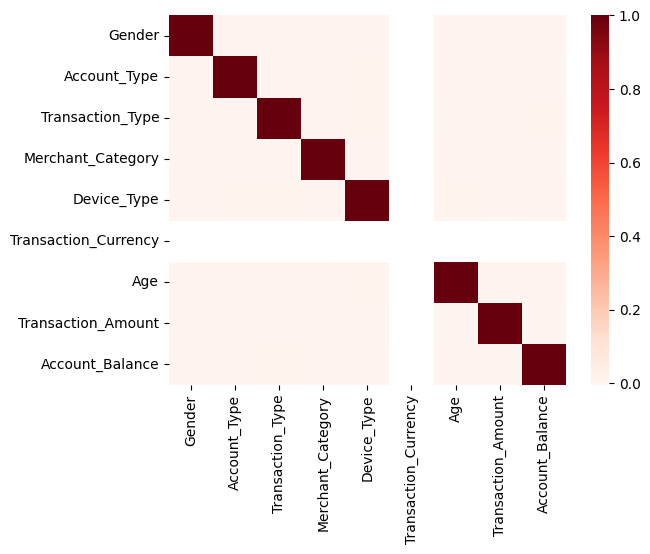

In [162]:
# Checking for any correlation between features
sns.heatmap(X_cleaned.corr(),
            cmap = "Reds"
            )

In [163]:
X_cleaned["Transaction_Currency"].value_counts()

Transaction_Currency
0.0    200000
Name: count, dtype: int64

Remark 2: There is no correlation between features. Furthermore, the column "Transation_Currency" shows any correlation with other features, because there is only 1 value, consequently we can drop this column. 

In [164]:
columns_selected.remove("Transaction_Currency")

ValueError: list.remove(x): x not in list

In [169]:
X_cleaned = X_cleaned[columns_selected]

In [170]:
X_cleaned

,Gender,Account_Type,Transaction_Type,Merchant_Category,Device_Type,Age,Transaction_Amount,Account_Balance
0,1.0,2.0,3.0,5.0,3.0,60,32415.45,74557.27
1,0.0,0.0,0.0,5.0,1.0,51,43622.60,74622.66
2,1.0,2.0,0.0,3.0,1.0,20,63062.56,66817.99
3,0.0,0.0,2.0,2.0,2.0,57,14000.72,58177.08
4,0.0,2.0,3.0,2.0,2.0,43,18335.16,16108.56
...,...,...,...,...,...,...,...,...
199995,0.0,0.0,1.0,5.0,0.0,55,98513.74,37475.11
199996,1.0,0.0,4.0,3.0,0.0,51,40593.55,53037.20
199997,0.0,2.0,4.0,4.0,1.0,41,61579.70,96225.36
199998,0.0,1.0,2.0,1.0,1.0,28,39488.22,89599.90


## Data Preparation for ML algorithm

### 1) We will standardize the data (meaning for each column we adjust the values to have a mean = 0 and std = 1)to better compare the values between each other. <br>
Standardizing the values implies the dataset follows a normal distribution, which is not necessary the case. 

In [147]:
# Standardization of the dataset
scaler = StandardScaler()
X_cleaned = scaler.fit_transform(X_cleaned)
df_cleaned = pd.DataFrame(X_cleaned, columns = columns_selected)

In [171]:
# Checking for imbalanced data
y.value_counts(normalize=True)

Is_Fraud
0    0.94956
1    0.05044
Name: proportion, dtype: float64

Remark 3: Imbalanced data in the dataset is defined by having a disproportion between the classes (here two classes). <br>
In our case, we have around 95% of non-fraud responses and 5% of fraud responses. <br>
Imbalanced data can impact the training of our algorithm, by learning more of the non-fraud responses than the fraud ones. <br>
It can influence the Recall of the algorithm (we will talk later about evaluation and metrics for classification models.). <br>In other words, detecting the fraud transaction even for correct ones is more important than not predicting the fraud and being able to detect a correct transaction. 

In [ ]:
# Oversampling the data, meaning increasing the number of instances of fraud detections to be equal as non-fraud instances. 
smote=SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_cleaned,y)

/Users/socheat/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [180]:
y_resampled.value_counts(normalize=True)

Is_Fraud
0    0.5
1    0.5
Name: proportion, dtype: float64

### 2) Splitting the dataset into training, testing and validation sets

In [186]:
# Creating all the sets : 80% training set, 10% testing set, 10% validation set

X_train, X_test_valid, y_train, y_test_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

### 3) Defining the models

In [ ]:
# Defining the models

models = {
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Gradient Boosting":GradientBoostingClassifier()
}

# Custom scorer for recall
scorer = make_scorer(recall_score)

best_model = None
best_recall = 0
best_model_name = ""

# Train models and evaluate recall using cross-validation
for name, model in models.items():
    recall = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer).mean()
    print(f"{name} Recall: {recall:.4f}")
    
    if recall > best_recall:
        best_recall = recall
        best_model = model
        best_model_name = name

Random Forest Recall: 0.9453
K-Nearest Neighbors Recall: 0.8560
